# Retinopathy Classification

## Submit result to kaggle as Part3 HW: https://www.kaggle.com/c/retinopathy-classification-sai

## HINT

1.   Select model from keras application
2.   Transfer learning
3.   Data Augmentation
4.   More imaage preprocess (ex: histogram equlization, crop image, ... etc)



In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, models, layers, utils, activations, losses, optimizers, metrics
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import pandas as pd

In [ ]:
# Define Parameters
num_classes = 3
IMG_SIZE = 224

In [ ]:
# download from google drive or upload file by yourself
!gdown --id '1QHVsHvYPUw6IhOYn7ayUkZ_L95KVcPQ4' --output retina-dataset.zip

Downloading...
From: https://drive.google.com/uc?id=1QHVsHvYPUw6IhOYn7ayUkZ_L95KVcPQ4
To: /content/retina-dataset.zip
35.1MB [00:00, 160MB/s]


In [ ]:
# unzip dataset file
!unzip -q retina-dataset.zip

#### Data Visualization

In [ ]:
paths = glob('retina-train/*.jpeg')
paths_test = sorted(glob('retina-test/*.jpeg'))
len(paths), len(paths_test)

(2086, 522)

retina-train/38956_left_0.jpeg


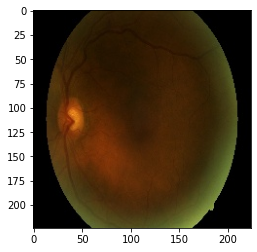

In [ ]:
idx = np.random.randint(0, len(paths), size=1)[0]
path = paths[idx]
# path = 'retina-train/5258_right_2.jpeg'
img = cv2.imread(path)# [:,:,::-1]
plt.imshow(img[:,:,::-1])
print(path)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
all_filenames = [os.path.split(p)[1] for p in paths] # path -> ***.jpeg
print(all_filenames[:3])
all_cls = [int(name.split('.')[0].split('_')[-1]) for name in all_filenames] # ***.jpeg -> 0~4
print(all_cls[:3])

['21373_left_2.jpeg', '24262_right_0.jpeg', '43362_left_0.jpeg']
[2, 0, 0]


<BarContainer object of 3 artists>

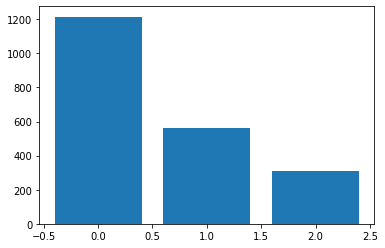

In [ ]:
# Class distribution
cls, count = np.unique(all_cls, return_counts=True)
plt.bar(cls, count)

#### Build Transfer Learning Model

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
# Build model
base_model = tf.keras.applications.Xception(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
predictions = layers.Dense(3, activation='softmax')(x)
model = models.Model(base_model.input, predictions)

In [ ]:

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

#### Prepare Data

In [ ]:
# split dataset
path_train, path_val = train_test_split(paths, test_size=0.2)
base_model = tf.keras.applications.Xception(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
len(path_train), len(path_val)

(1668, 418)

In [ ]:
def create_dataset(paths, img_size=IMG_SIZE, num_classes=num_classes, test=False):
    num_data = len(paths)
    x_data = np.empty((num_data, img_size, img_size, 3))
    y_data = np.empty((num_data))

    for i, path in enumerate(tqdm(paths)):
        # read image and preprocess
        img = cv2.imread(path)[:,:,::-1]
        img = cv2.resize(img, (img_size, img_size))
        # !!!!!!!!! Use model preprocessing function !!!!!!!!!!
        img = tf.keras.applications.xception.preprocess_input(img)  
        x_data[i] = img

        if not test:
            # read class label
            filename = os.path.split(path)[1]
            cls = int(filename.split('.')[0].split('_')[-1]) # '38200_left_0.jpeg' -> 0
            y_data[i] = cls
    if not test:
        y_data = utils.to_categorical(y_data, num_classes=num_classes)
        return x_data, y_data
    else:
        return x_data

In [ ]:
x_train, y_train = create_dataset(path_train)
x_val, y_val = create_dataset(path_val)
x_test = create_dataset(paths_test, test=True)

100%|██████████| 522/522 [00:00<00:00, 638.20it/s]


In [ ]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((1668, 224, 224, 3), (1668, 3), (418, 224, 224, 3), (418, 3))

#### Training

In [ ]:
model.compile(optimizer='adam', 
              loss=losses.categorical_crossentropy, 
              metrics=[metrics.categorical_accuracy])

In [ ]:
# Add data augmentation


logs = model.fit(x_train, y_train,
                batch_size=32,
                epochs=10,
                validation_data=(x_val, y_val))

Epoch 1/10
53/53 [==============================] - 72s 664ms/step - loss: 0.8422 - categorical_accuracy: 0.6145 - val_loss: 4.3664 - val_categorical_accuracy: 0.6268
Epoch 2/10
53/53 [==============================] - 33s 627ms/step - loss: 0.6862 - categorical_accuracy: 0.6888 - val_loss: 1.4054 - val_categorical_accuracy: 0.6794
Epoch 3/10
53/53 [==============================] - 33s 616ms/step - loss: 0.6193 - categorical_accuracy: 0.7284 - val_loss: 0.9486 - val_categorical_accuracy: 0.6722
Epoch 4/10
53/53 [==============================] - 33s 618ms/step - loss: 0.5586 - categorical_accuracy: 0.7632 - val_loss: 2.1496 - val_categorical_accuracy: 0.5981
Epoch 5/10
53/53 [==============================] - 33s 620ms/step - loss: 0.4084 - categorical_accuracy: 0.8381 - val_loss: 4.1433 - val_categorical_accuracy: 0.6100
Epoch 6/10
53/53 [==============================] - 33s 618ms/step - loss: 0.2627 - categorical_accuracy: 0.8945 - val_loss: 3.1062 - val_categorical_accuracy: 0.641

#### Make Submission file

In [ ]:
predictions = np.argmax(model.predict(x_test), axis=-1)

df = pd.DataFrame()
df['Id'] = [p.split(os.sep)[-1] for p in paths_test]
df['Category'] = predictions
df.to_csv('submission.csv', index=None)
df

,Id,Category
0,10017_left.jpeg,0
1,10031_right.jpeg,0
2,10150_left.jpeg,0
3,10154_right.jpeg,0
4,10440_right.jpeg,0
...,...,...
517,9608_left.jpeg,2
518,9673_right.jpeg,0
519,9690_left.jpeg,0
520,9717_right.jpeg,0
